In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.cm as cm 
import pickle
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from minisom import MiniSom  
import math

from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from tslearn.clustering import silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_samples


In [2]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

In [3]:
df_solar_satellite = pd.read_csv('../../1_data_analysis_and_preproc/intermediate/solar/solar_satellite_merged_raw.csv')

In [4]:
df_solar_satellite.head()

,asset_id,read_at,ac_power,ac_voltage,ac_current,dc_power,dc_voltage,dc_current,farm,global_tilted_irradiance,global_horizontal_irradiance,temperature,cloud_cover
0,11,2022-01-01 07:40:00,0.0,4.0,0.000,0.0000,2.73333,0.000,1,0.0,0.0,12.2,21.9
1,12,2022-01-01 07:40:00,0.0,3.0,0.000,0.0000,1.90000,0.000,1,0.0,0.0,12.2,21.9
2,13,2022-01-01 07:40:00,0.0,2.0,0.000,0.0000,2.10000,0.000,1,0.0,0.0,12.2,21.9
3,14,2022-01-01 07:40:00,13.0,232.0,0.113,14.1887,346.06700,0.041,1,0.0,0.0,12.2,21.9
4,15,2022-01-01 07:40:00,0.0,232.0,0.018,0.8127,270.90000,0.003,1,0.0,0.0,12.2,21.9


In [5]:
assets = df_solar_satellite['asset_id'].unique()
total_len = 0 

for asset in assets:
    new_len = len(df_solar_satellite[df_solar_satellite['asset_id'] == asset])
    if new_len != total_len:
        print(f'asset {asset} has a different number of rows: {new_len}')
        total_len = new_len 

asset 11 has a different number of rows: 52147
asset 12 has a different number of rows: 62780
asset 13 has a different number of rows: 52333
asset 14 has a different number of rows: 52276
asset 15 has a different number of rows: 52190
asset 16 has a different number of rows: 52287
asset 17 has a different number of rows: 52279
asset 18 has a different number of rows: 52227
asset 19 has a different number of rows: 52288
asset 110 has a different number of rows: 51886
asset 111 has a different number of rows: 52261
asset 112 has a different number of rows: 52239
asset 21 has a different number of rows: 52143
asset 22 has a different number of rows: 52188
asset 23 has a different number of rows: 52159
asset 24 has a different number of rows: 47384
asset 25 has a different number of rows: 51262
asset 26 has a different number of rows: 52117
asset 27 has a different number of rows: 51394
asset 28 has a different number of rows: 52250
asset 29 has a different number of rows: 52144
asset 210 

even without cleaning the number of rows per asset is not the same

In [6]:
np.random.seed(10)

# Define the desired subset size per asset --> guarantee that each asset has the same amount of rows
subset_size_percentage = 1  # Adjust as needed

# Get the unique asset identifiers from the original DataFrame
unique_assets = df_solar_satellite['asset_id'].unique()

# Find the minimum number of rows among all assets
min_rows = min(df_solar_satellite['asset_id'].value_counts())

# Calculate the subset size based on the minimum number of rows
subset_size = int(subset_size_percentage * min_rows)

# Initialize an empty list to store the sampled data
subset_data = []

# Iterate over each asset, sample rows, and append to subset_data
for asset in unique_assets:
    # Filter the DataFrame for the current asset
    asset_df = df_solar_satellite[df_solar_satellite['asset_id'] == asset]
    
    # Sample rows from the asset DataFrame
    sampled_group = asset_df.sample(n=subset_size, replace=False)
    subset_data.append(sampled_group)

# Concatenate the sampled data from all assets into a single DataFrame
df_subset = pd.concat(subset_data)


In [7]:
df_subset['asset_id'].nunique()

77

In [8]:
len(df_subset)

992453

In [9]:
df_subset = df_subset.reset_index(drop=True)

In [10]:
df_subset['read_at'] = pd.to_datetime(df_subset['read_at'])

In [11]:
df_subset['read_at'] = df_subset['read_at'].apply(pd.Timestamp.timestamp).values.reshape(-1, 1)

the variables to include for the model should be dc_power, dc_voltage, dc_current, temperature and cloud_cover, as global_tilted_irradiance and global_horizontal_irradiance have very high correlation with other variables and keeping them, would be reductant

however, in the time series clustering, we'll want to do one variable at a time and then all of them.

In [12]:
X = df_subset[['asset_id','read_at', 'dc_power', 'dc_voltage', 'dc_current', 'temperature', 'cloud_cover']]
X.head()

,asset_id,read_at,dc_power,dc_voltage,dc_current,temperature,cloud_cover
0,11,1.692560e+09,1.46373,182.967,0.008,19.0,19.0
1,11,1.651947e+09,726.21900,304.367,2.386,20.4,0.0
2,11,1.679590e+09,861.01400,317.600,2.711,17.0,29.0
3,11,1.658645e+09,161.37300,288.167,0.560,16.0,72.0
4,11,1.673791e+09,5536.75000,303.833,18.223,12.0,2.0


In [13]:
X.dtypes

asset_id         int64
read_at        float64
dc_power       float64
dc_voltage     float64
dc_current     float64
temperature    float64
cloud_cover    float64
dtype: object

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992453 entries, 0 to 992452
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   asset_id     992453 non-null  int64  
 1   read_at      992453 non-null  float64
 2   dc_power     992453 non-null  float64
 3   dc_voltage   992453 non-null  float64
 4   dc_current   992453 non-null  float64
 5   temperature  992453 non-null  float64
 6   cloud_cover  992453 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 53.0 MB


In [15]:
X = X.astype(np.float32)

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992453 entries, 0 to 992452
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   asset_id     992453 non-null  float32
 1   read_at      992453 non-null  float32
 2   dc_power     992453 non-null  float32
 3   dc_voltage   992453 non-null  float32
 4   dc_current   992453 non-null  float32
 5   temperature  992453 non-null  float32
 6   cloud_cover  992453 non-null  float32
dtypes: float32(7)
memory usage: 26.5 MB


In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['read_at', 'dc_power', 'dc_voltage', 'dc_current', 'temperature', 'cloud_cover']])
X_scaled = pd.DataFrame(X_scaled)

In [18]:
X_scaled['asset_id'] = X['asset_id']

In [19]:
X_grouped = X.groupby('asset_id')

## Time Series Clustering with all important variables

https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html#sphx-glr-auto-examples-clustering-plot-kmeans-py

### Euclidean k-Means

to be able to have actual time series, the data were grouped by asset id. if that is not done the algorithm will assume that every row of the df is a different time series and we would have 43736 time series instead of 77 (the number of assets) (the graphs explain it better:)

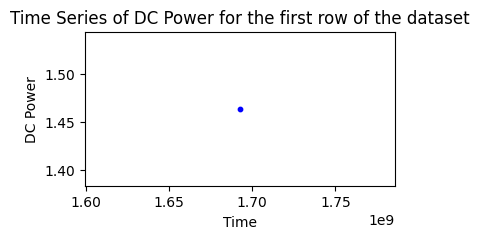

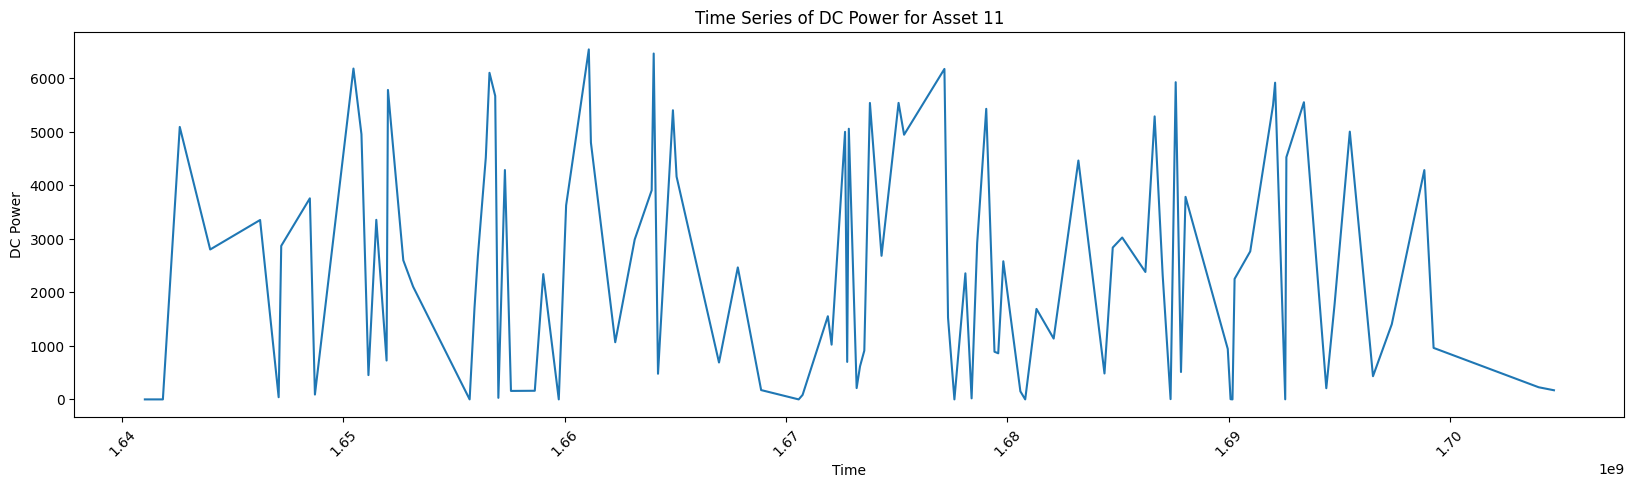

In [20]:
first_row = df_subset.iloc[0]
# Plotting a single dot with custom size
plt.figure(figsize=(4, 2))
plt.scatter(first_row['read_at'], first_row['dc_power'], s=10, color='b')
plt.xlabel('Time')
plt.ylabel('DC Power')
plt.title('Time Series of DC Power for the first row of the dataset')
plt.show()

# Selecting the first row and grouping by asset_id
first_group = df_subset[df_subset['asset_id'] == 11][:100]

# Sort the dataframe by 'read_at' column
first_group = first_group.sort_values(by='read_at')

# Plotting the time series
plt.figure(figsize=(20, 5))
plt.plot(first_group['read_at'], first_group['dc_power'])
plt.xlabel('Time')
plt.ylabel('DC Power')
plt.title('Time Series of DC Power for Asset 11')
plt.xticks(rotation=45)
plt.show()

In [21]:
X_scaled.columns = ['read_at', 'dc_power', 'dc_voltage', 'dc_current', 'temperature', 'cloud_cover', 'asset_id']

In [22]:
# Grouping by 'asset_id' and storing each group as an array
grouped_arrays_all = [group[['read_at', 'dc_power', 'dc_voltage', 'dc_current', 'temperature', 'cloud_cover']].values \
                    for _, group in X_scaled.groupby('asset_id')]

In [23]:
X_train = np.array(grouped_arrays_all)

In [24]:
sz = X_train.shape[1]

In [25]:
train_pca = X_train.reshape(X_train.shape[0], -1)
pca = PCA(n_components = 2)
train_pca = pca.fit_transform(train_pca)

In [26]:
seed = 42

In [27]:
Sum_of_squared_distances = []
K = range(1,8)
for k in K:
    KM = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=0)

    KM = KM.fit(train_pca)
    Sum_of_squared_distances.append(KM.inertia_)

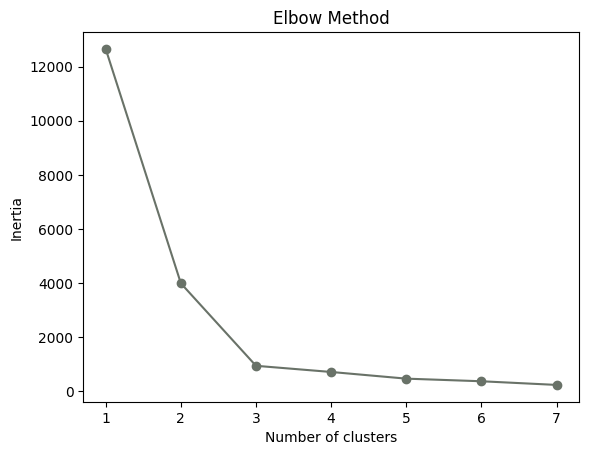

In [28]:
plt.plot(range(1,8), Sum_of_squared_distances, marker = 'o', c = '#697268')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

by the elbow plot, the optimum number of clusters is 3. we'll also do another analysis with the silhouette score:

For n_clusters = 2 The average silhouette_score is : 0.79
For n_clusters = 3 The average silhouette_score is : 0.85
For n_clusters = 4 The average silhouette_score is : 0.84
For n_clusters = 5 The average silhouette_score is : 0.64


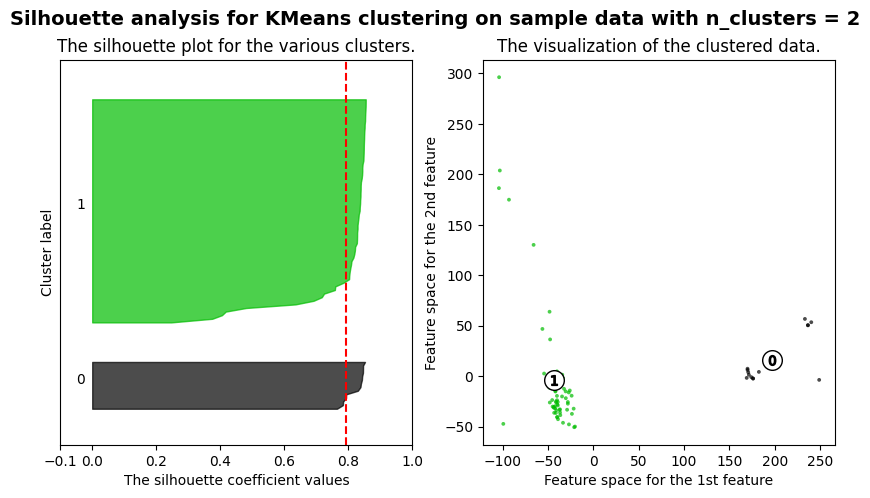

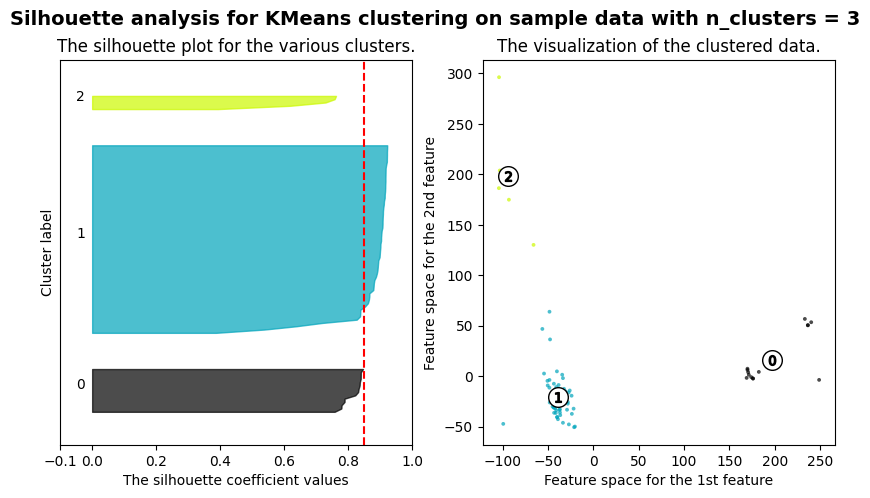

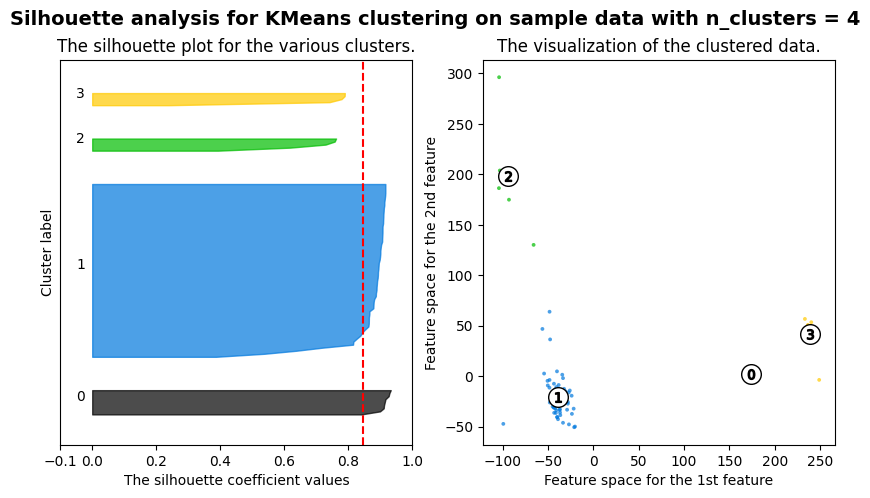

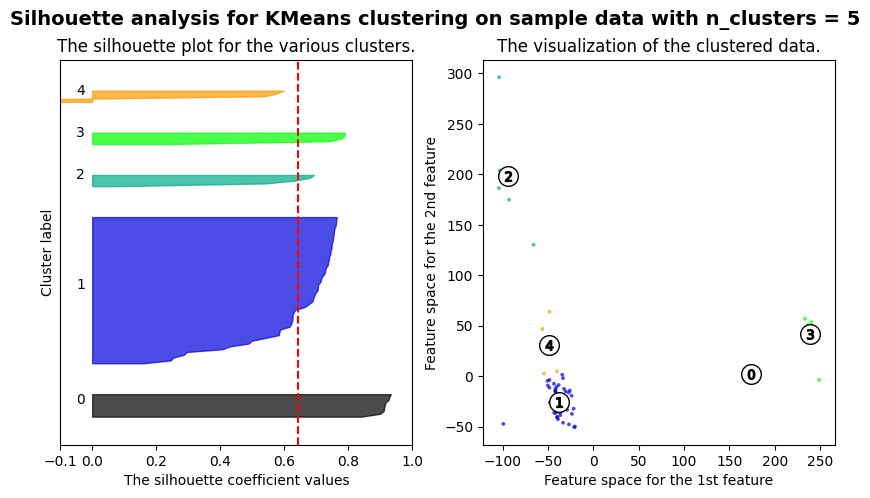

In [29]:
X = train_pca

range_n_clusters = [2,3,4,5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = TimeSeriesKMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is : {:.2f}"
        .format(silhouette_avg),
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


we have to look not only to the average silhouette score, but also for the partition that has the best silhouette score for the individual clusters

using 3 clusters as is the best in the silhouette analysis due to the similar distribution of the silhouette score among the clusters 

In [30]:
def zoom_in_plot(X_train, y_pred, cluster_centers, sz, title:str, num_clusters, som: bool = False):
    fig = plt.figure(figsize=(16, 4*num_clusters))
    gs = gridspec.GridSpec(num_clusters, 4, width_ratios=[5, 1, 3, 1], height_ratios=[1] * num_clusters)

    cluster_num = 0
    
    som_to_plot = np.unique(y_pred)

    indexes_to_plot = []

    num_clusters_to_plot = num_clusters
    if som:
        num_clusters_to_plot = len(som_to_plot) 

    for i in range(num_clusters_to_plot):
        cluster_num = som_to_plot[i] if som else i
        
        if cluster_num > len(cluster_centers):
            continue

        # Main plot with more width
        ax = plt.subplot(gs[i, 0])

        for xx in X_train[y_pred == cluster_num]:  
            ax.plot(xx.ravel(), "k-", alpha=0.2)
        if som:
            ax.plot(pca.inverse_transform(cluster_centers)[cluster_num-1].ravel(), "r-")  # Plot cluster centers in original data space
        else:
            ax.plot(pca.inverse_transform(cluster_centers)[cluster_num].ravel(), "r-")  # Plot cluster centers in original data space
        ax.set_xlim(0, sz)
        ax.set_ylim(-6, 6)
        ax.text(0.55, 0.85, 'Cluster %d' % (cluster_num), transform=ax.transAxes)
        if i == 0:
            ax.set_title(f"{title}")

        # Zoomed-in plot
        axins = plt.subplot(gs[i, 2])
        for xx in X_train[y_pred == cluster_num]:  
            axins.plot(xx.ravel(), "k-", alpha=0.2)
        if som:
            axins.plot(pca.inverse_transform(cluster_centers)[cluster_num-1].ravel(), "r-")  # Plot cluster centers in original data space
        else:
            axins.plot(pca.inverse_transform(cluster_centers)[cluster_num].ravel(), "r-")  # Plot cluster centers in original data space
        axins.set_xlim(6000, 6020)
        axins.set_ylim(-5, 5.5)
        x_ticks = [6000, 6005, 6010, 6015, 6020]
        # Set the x-ticks for the zoomed-in plot
        axins.set_xticks(x_ticks)
        plt.xticks(rotation=20)
        mark_inset(ax, axins, loc1=2, loc2=3, fc="None", ec="g")

    # Adjust spacing between the two plots in the same row
    plt.subplots_adjust(wspace=0)

    # plt.tight_layout()
    plt.show()

Euclidean k-means
1516.337 --> 936.829 --> 936.829 --> 


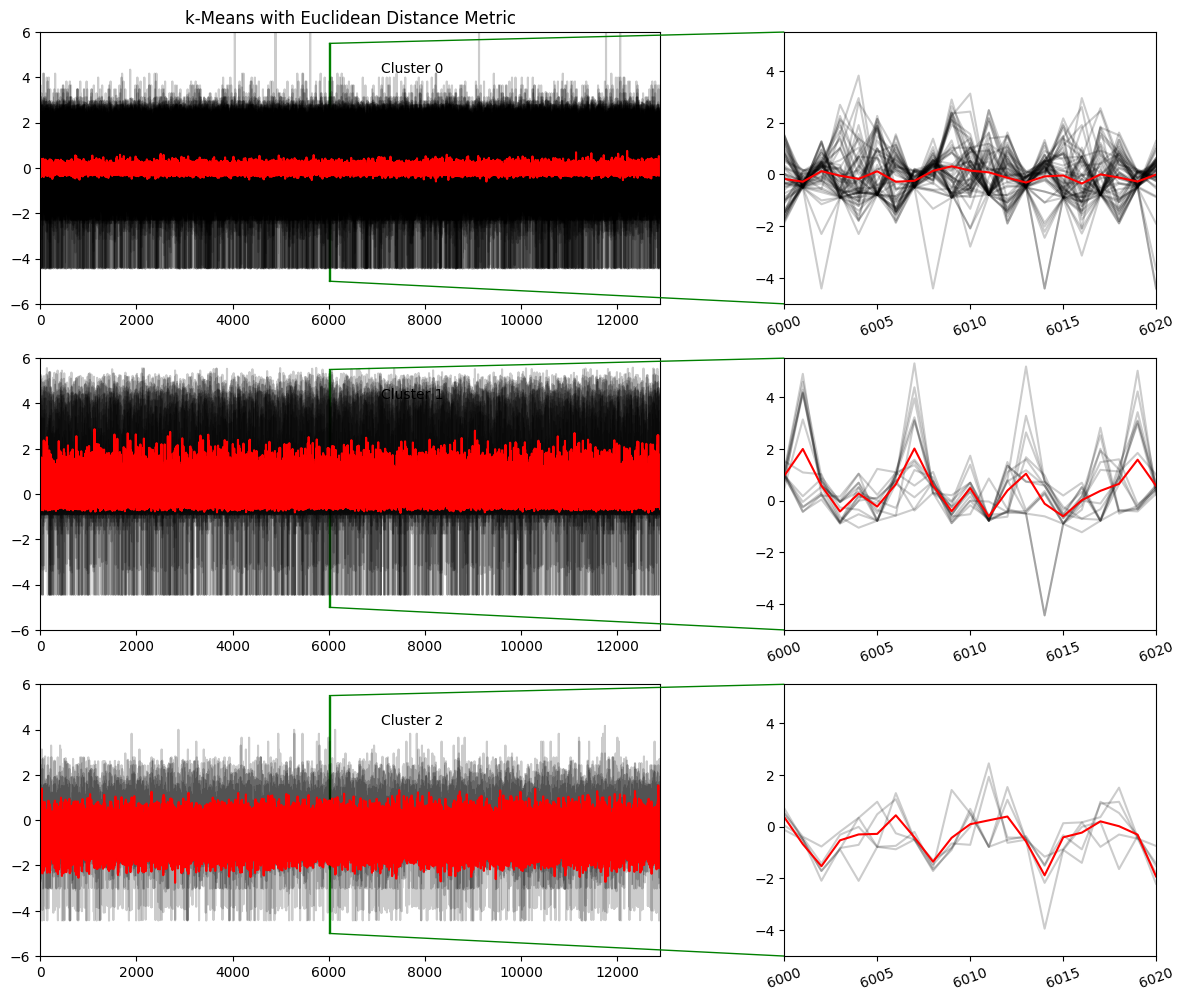

In [31]:
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
y_pred_euclidean = km.fit_predict(train_pca)

cluster_centers_reshaped = km.cluster_centers_.reshape(3, 2)

zoom_in_plot(X_train, y_pred_euclidean, cluster_centers_reshaped, sz, 'k-Means with Euclidean Distance Metric', num_clusters=3)


In [32]:
with open('intermediate_with_out/euclidean_solar.pickle', 'wb') as f:
    pickle.dump(km, f)

with open('intermediate_with_out/euclidean_labels.pickle', 'wb') as f:
    pickle.dump(y_pred_euclidean, f)

In [33]:
with open('intermediate_with_out/euclidean_solar.pickle', 'rb') as f:
    km = pickle.load(f)

with open('intermediate_with_out/euclidean_labels.pickle', 'rb') as f:
    y_pred_euclidean = pickle.load(f)

In [34]:
assets_per_cluster_euclidean = pd.DataFrame()

assets_per_cluster_euclidean['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_euclidean['cluster_label'] = y_pred_euclidean

In [35]:
assets_clusters = assets_per_cluster_euclidean.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.tolist()}")

Cluster 0: [13, 14, 15, 16, 17, 18, 19, 110, 111, 112, 21, 22, 23, 24, 25, 26, 27, 28, 29, 210, 211, 212, 213, 214, 216, 217, 215, 31, 32, 33, 34, 36, 37, 317, 41, 42, 43, 44, 45, 46, 48, 49, 410, 413, 414, 416, 417, 411, 412, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Cluster 1: [38, 39, 310, 311, 312, 313, 314, 315, 316, 510, 511, 512, 513, 514]
Cluster 2: [11, 12, 35, 47, 415]


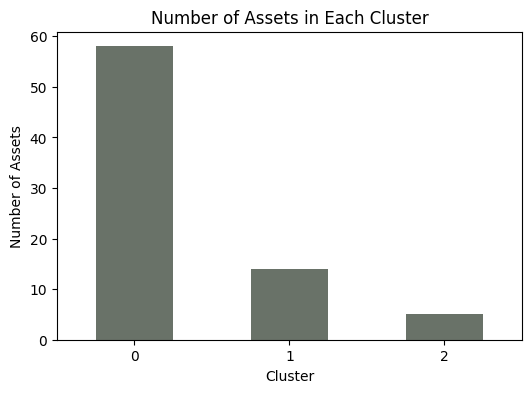

In [36]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_euclidean['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [37]:
asset_per_cluster = pd.DataFrame(columns=['Metric', 'Cluster 0', 'Cluster 1', 'Cluster 2'])

for cluster_label, count in cluster_counts.items():
    column_name = f'Cluster {cluster_label}'  # Generate column name dynamically
    asset_per_cluster.loc[0, column_name] = count

asset_per_cluster.loc[0, 'Metric'] = 'Euclidean'

asset_per_cluster

,Metric,Cluster 0,Cluster 1,Cluster 2
0,Euclidean,58,14,5


In [38]:
merged_df = df_subset.merge(assets_per_cluster_euclidean, on='asset_id', how='left')

In [39]:
merged_df.to_csv('intermediate_with_out/results_clean_solar_euclidean.csv', index = False)

### k-Means with DTW distance metric

In [40]:
# dtw-k-means
print("dtw k-means")
dtw_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)

y_pred_dtw = dtw_km.fit_predict(train_pca)

dtw k-means
Init 1
1457.951 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


936.829 --> 936.829 --> 
Init 2


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


3209.937 --> 1156.739 --> 974.881 --> 936.829 --> 936.829 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


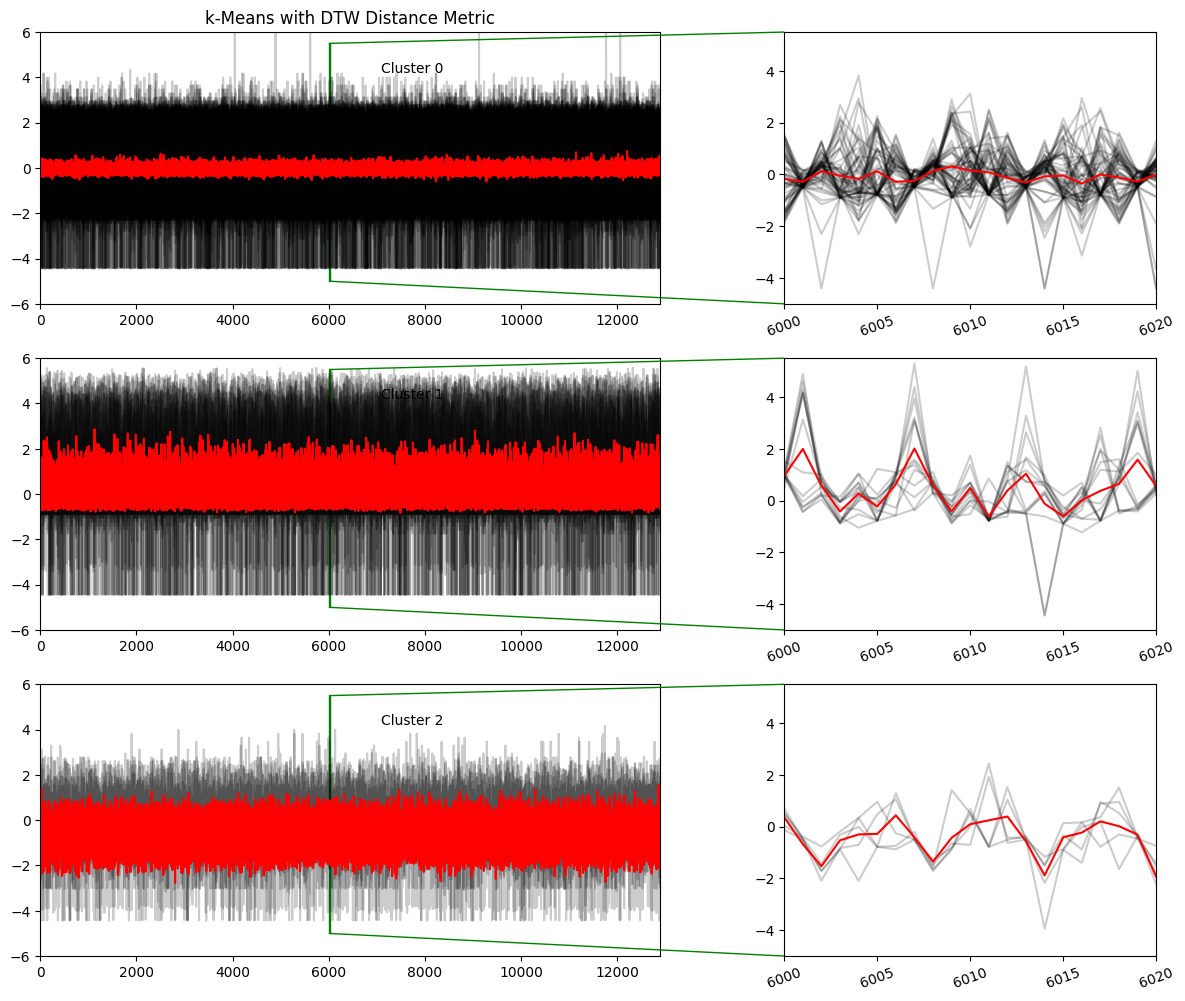

In [41]:
cluster_centers_reshaped = dtw_km.cluster_centers_.reshape(3, 2)

zoom_in_plot(X_train, y_pred_dtw, cluster_centers_reshaped, sz, 'k-Means with DTW Distance Metric', num_clusters=3)

In [42]:
with open('intermediate_with_out/dtw_solar.pickle', 'wb') as f:
    pickle.dump(dtw_km, f)

with open('intermediate_with_out/dtw_labels.pickle', 'wb') as f:
    pickle.dump(y_pred_dtw, f)

In [43]:
with open('intermediate_with_out/dtw_solar.pickle', 'rb') as f:
    dtw_km = pickle.load(f)

with open('intermediate_with_out/dtw_labels.pickle', 'rb') as f:
    y_pred_dtw = pickle.load(f)

In [44]:
assets_per_cluster_dtw = pd.DataFrame()

assets_per_cluster_dtw['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_dtw['cluster_label'] = y_pred_dtw

In [45]:
assets_clusters = assets_per_cluster_dtw.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.tolist()}")

Cluster 0: [13, 14, 15, 16, 17, 18, 19, 110, 111, 112, 21, 22, 23, 24, 25, 26, 27, 28, 29, 210, 211, 212, 213, 214, 216, 217, 215, 31, 32, 33, 34, 36, 37, 317, 41, 42, 43, 44, 45, 46, 48, 49, 410, 413, 414, 416, 417, 411, 412, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Cluster 1: [38, 39, 310, 311, 312, 313, 314, 315, 316, 510, 511, 512, 513, 514]
Cluster 2: [11, 12, 35, 47, 415]


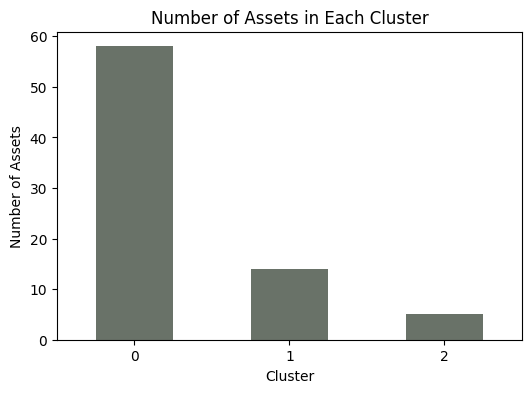

In [46]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_dtw['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [47]:
for cluster_label, count in cluster_counts.items():
    column_name = f'Cluster {cluster_label}'  # Generate column name dynamically
    asset_per_cluster.loc[1, column_name] = count

asset_per_cluster.loc[1, 'Metric'] = 'Dtw'

asset_per_cluster

,Metric,Cluster 0,Cluster 1,Cluster 2
0,Euclidean,58,14,5
1,Dtw,58,14,5


In [48]:
merged_df = df_subset.merge(assets_per_cluster_dtw, on='asset_id', how='left')

In [49]:
merged_df.to_csv('intermediate_with_out/results_clean_solar_dtw.csv', index = False)

## Soft DTW k-means

In [50]:
# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=3,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
                           
y_pred_soft_dtw = sdtw_km.fit_predict(train_pca)

Soft-DTW k-means
8523046.854 --> 3749160.359 --> 3749197.304 --> 3749197.304 --> 


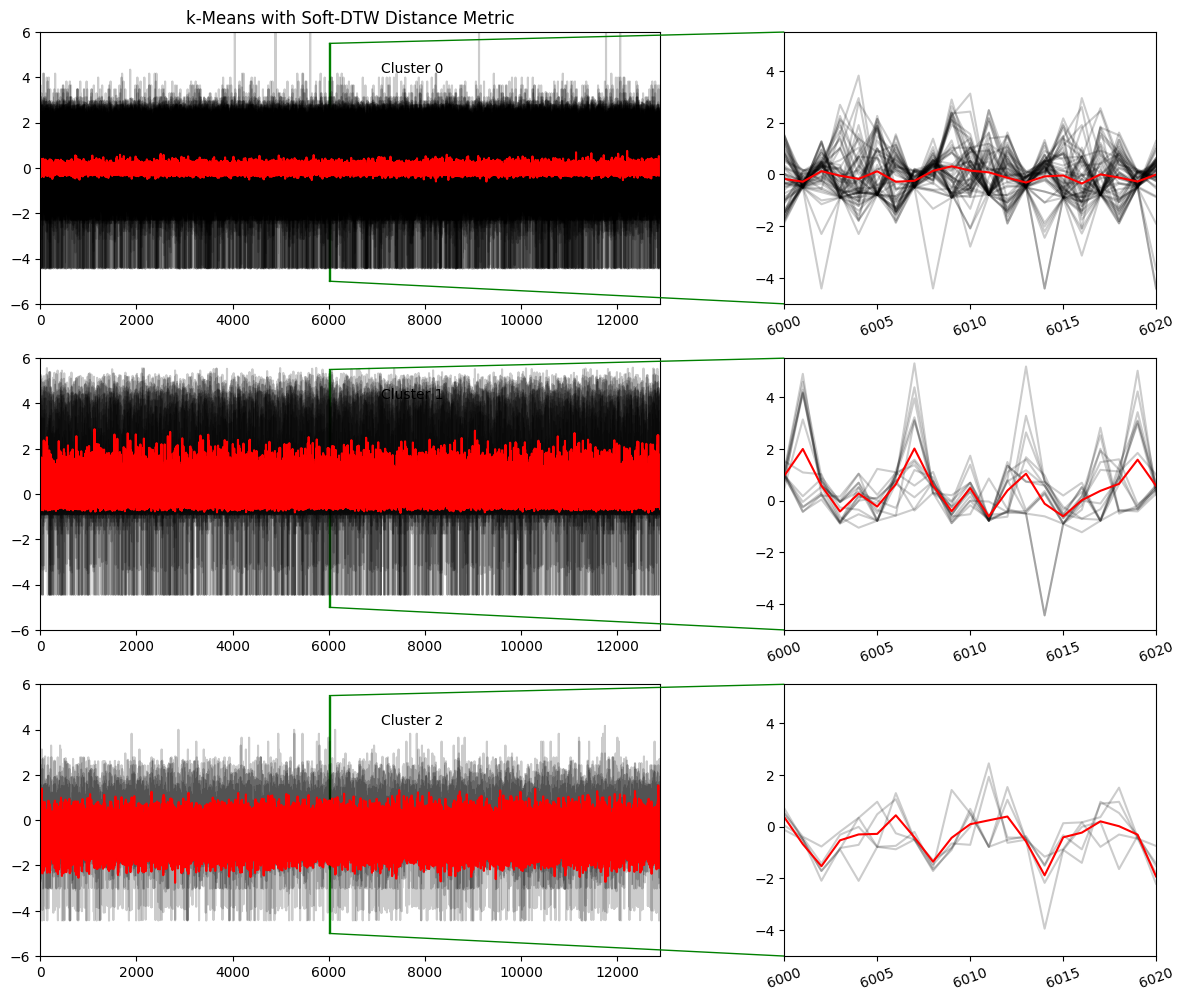

In [51]:
cluster_centers_reshaped = sdtw_km.cluster_centers_.reshape(3, 2)

#zoom_in_plot(X_train, y_pred_euclidean, km, sz, 'k-Means with Euclidean Distance Metric')
zoom_in_plot(X_train, y_pred_soft_dtw, cluster_centers_reshaped, sz, 'k-Means with Soft-DTW Distance Metric', num_clusters=3)

In [52]:
with open('intermediate_with_out/SDTW_solar.pickle', 'wb') as f:
    pickle.dump(sdtw_km, f)

with open('intermediate_with_out/SDTW_labels.pickle', 'wb') as f:
    pickle.dump(y_pred_soft_dtw, f)

In [53]:
with open('intermediate_with_out/SDTW_solar.pickle', 'rb') as f:
    sdtw_km = pickle.load(f)

with open('intermediate_with_out/SDTW_labels.pickle', 'rb') as f:
    y_pred_soft_dtw = pickle.load(f)

In [54]:
assets_per_cluster_soft_dtw = pd.DataFrame()

assets_per_cluster_soft_dtw['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_soft_dtw['cluster_label'] = y_pred_soft_dtw

In [55]:
assets_clusters = assets_per_cluster_soft_dtw.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.tolist()}")

Cluster 0: [13, 14, 15, 16, 17, 18, 19, 110, 111, 112, 21, 22, 23, 24, 25, 26, 27, 28, 29, 210, 211, 212, 213, 214, 216, 217, 215, 31, 32, 33, 34, 36, 37, 317, 41, 42, 43, 44, 45, 46, 48, 49, 410, 413, 414, 416, 417, 411, 412, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Cluster 1: [38, 39, 310, 311, 312, 313, 314, 315, 316, 510, 511, 512, 513, 514]
Cluster 2: [11, 12, 35, 47, 415]


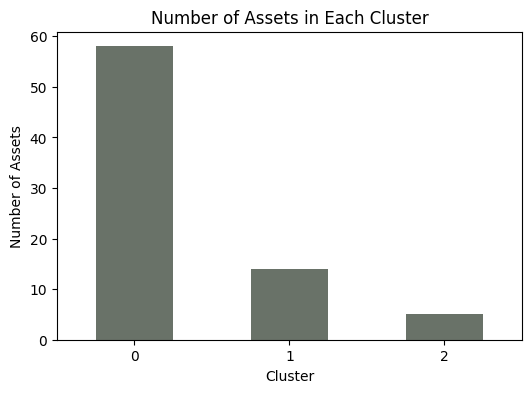

In [56]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_soft_dtw['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [57]:
for cluster_label, count in cluster_counts.items():
    column_name = f'Cluster {cluster_label}'  # Generate column name dynamically
    asset_per_cluster.loc[2, column_name] = count

asset_per_cluster.loc[2, 'Metric'] = 'Soft DTW'

asset_per_cluster

,Metric,Cluster 0,Cluster 1,Cluster 2
0,Euclidean,58,14,5
1,Dtw,58,14,5
2,Soft DTW,58,14,5


In [58]:
merged_df = df_subset.merge(assets_per_cluster_soft_dtw, on='asset_id', how='left')

In [59]:
merged_df.to_csv('intermediate_with_out/results_clean_solar_soft_dtw.csv', index = False)

## SOM

In [60]:
sil_scores = []
K = range(2,8)
for k in K:
    som_x = som_y = k
    mini_som = MiniSom(som_x, som_y,len(train_pca[0]), sigma=0.1, learning_rate = 1)
    mini_som.train(train_pca, 10000)

    win_map = mini_som.win_map(train_pca)
    
    cluster_map = []
    for idx in range(len(train_pca)):
        winner_node = mini_som.winner(train_pca[idx])
        cluster_map.append((train_pca[idx],winner_node[0]*som_y+winner_node[1]+1))

    cluster_df = pd.DataFrame(cluster_map,columns=["Series","Cluster"])

    sil = silhouette_score(train_pca, cluster_df['Cluster'])

    sil_scores.append(sil)

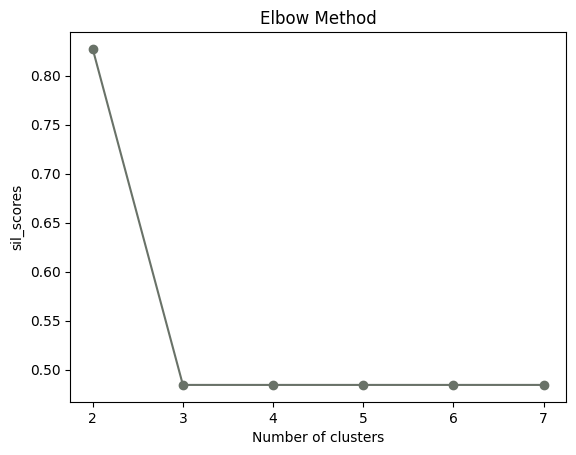

In [61]:
plt.plot(range(2,8), sil_scores, marker = 'o', c = '#697268')
plt.xlabel('Number of clusters')
plt.ylabel('sil_scores')
plt.title('Elbow Method')
plt.show()

In [62]:
som_x = som_y = 2

In [63]:
som = MiniSom(som_x, som_y,len(train_pca[0]), sigma=0.1, learning_rate = 1)

som.train(train_pca, 10000)

In [64]:
win_map = som.win_map(train_pca)

In [65]:
len(train_pca)

77

In [66]:
cluster_map = []
for idx in range(len(train_pca)):
    winner_node = som.winner(train_pca[idx])
    cluster_map.append((train_pca[idx],winner_node[0]*som_y+winner_node[1]+1))

cluster_df = pd.DataFrame(cluster_map,columns=["Series","Cluster"])

In [67]:
# Now, you can reshape the cluster centers for visualization
cluster_centers_reshaped = np.array([som.get_weights()[winner_node[0], winner_node[1]] for winner_node in np.ndindex(som_x, som_y)])
cluster_centers_reshaped = cluster_centers_reshaped.reshape((som_x * som_y, len(train_pca[0])))

In [68]:
y_pred_som = np.array(cluster_df["Cluster"])

In [69]:
num_clusters = len(cluster_df['Cluster'].unique())

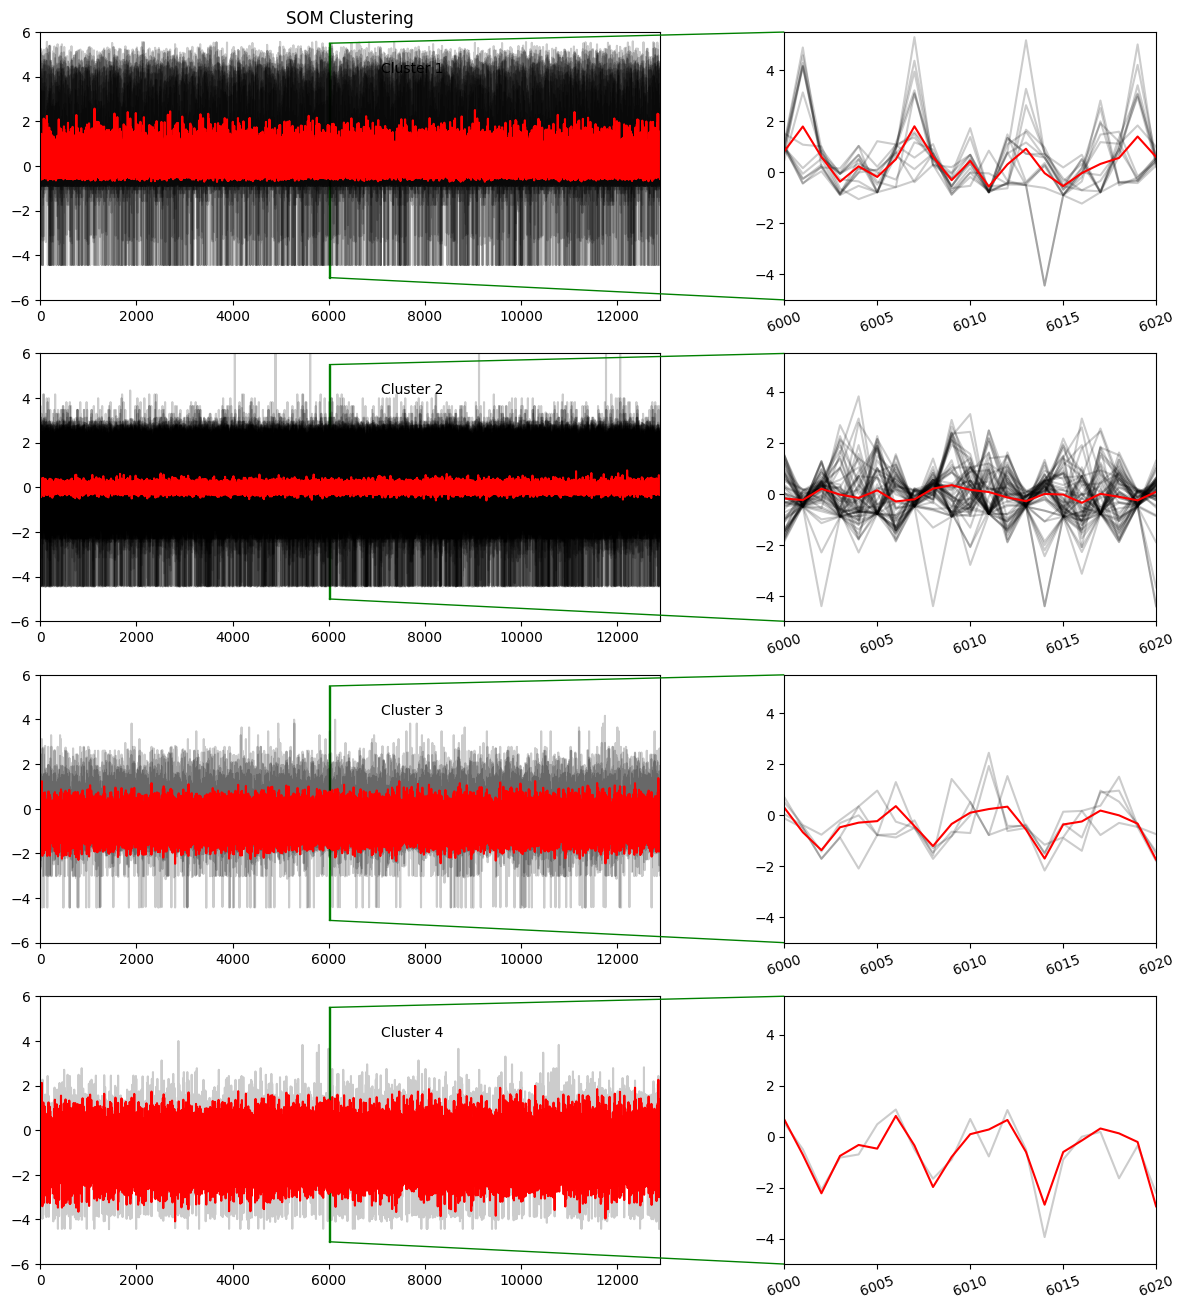

In [70]:
# Assuming you have a function zoom_in_plot defined for plotting
zoom_in_plot(X_train, y_pred_som, cluster_centers_reshaped, sz, 'SOM Clustering', num_clusters=num_clusters, som=True)

In [71]:
assets_per_cluster_som = pd.DataFrame()

assets_per_cluster_som['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_som['cluster_label'] = cluster_df['Cluster']

In [72]:
assets_clusters = assets_per_cluster_som.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 1: [36, 37, 38, 39, 40, 41, 42, 43, 44, 72, 73, 74, 75, 76]
Cluster 2: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
Cluster 3: [0, 33, 52, 58]
Cluster 4: [1]


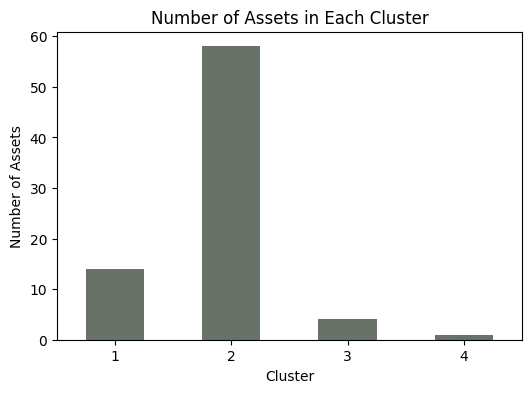

In [73]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_som['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [74]:
cluster_counts = assets_per_cluster_som['cluster_label'].value_counts().sort_index()

for cluster_label, count in cluster_counts.items():
    column_name = f'Cluster {cluster_label}'
    asset_per_cluster.loc[3, column_name] = f'{count:.0f}'

asset_per_cluster.loc[3, 'Metric'] = 'SOM'

asset_per_cluster

,Metric,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,Euclidean,58,14,5,n,n
1,Dtw,58,14,5,n,n
2,Soft DTW,58,14,5,n,n
3,SOM,NaN,14,58,4,1


# Evaluation

In [75]:
from scipy.spatial.distance import pdist, cdist

def dunn_index(points = train_pca, labels = y_pred_dtw):
    unique_labels = np.unique(labels)
    
    max_intra_cluster_distances = []
    min_inter_cluster_distance = float('inf')

    for label in unique_labels:
        cluster_points = points[labels == label]
        if len(cluster_points) > 1:
            intra_distances = pdist(cluster_points)
            max_intra_cluster_distances.append(np.max(intra_distances))
        else:
            max_intra_cluster_distances.append(0)

    for i, label_i in enumerate(unique_labels):
        cluster_points_i = points[labels == label_i]
        for j, label_j in enumerate(unique_labels):
            if label_i < label_j:
                cluster_points_j = points[labels == label_j]
                inter_distances = cdist(cluster_points_i, cluster_points_j)
                min_inter_cluster_distance = min(min_inter_cluster_distance, np.min(inter_distances))

    if len(max_intra_cluster_distances) == 0 or min_inter_cluster_distance == float('inf'):
        return 0

    return min_inter_cluster_distance / max(max_intra_cluster_distances)

In [76]:
# def xie_beni_index(points = train_pca, labels = y_pred_euclidean):
#     # Compute the total scatter
#     total_scatter = np.sum(pairwise_distances(points) ** 2) / (2 * len(points))
    
#     # Compute the intra-cluster scatter
#     cluster_labels = np.unique(labels)
#     intra_cluster_scatter = 0
#     for label in cluster_labels:
#         cluster_points = points[labels == label]
#         cluster_center = np.mean(cluster_points, axis=0)
#         intra_cluster_scatter += np.sum(np.linalg.norm(cluster_points - cluster_center, axis=1) ** 2)
#     intra_cluster_scatter /= len(points)
    
#     return intra_cluster_scatter / total_scatter


In [77]:
# Define a function to compute evaluation metrics
def compute_metrics(points = train_pca, labels = y_pred_euclidean, metric = 'euclidean'):

    metrics = {}
    
    metrics['Silhouette Score'] = silhouette_score(points, labels, metric)
    metrics['Davies-Bouldin Index'] = davies_bouldin_score(points, labels)
    metrics['Calinski-Harabasz Index'] = calinski_harabasz_score(points, labels)
    metrics['Dunn Index'] = dunn_index(points, labels)
    # metrics['Xie-Beni Index'] = xie_beni_index(points, labels)

    return metrics


In [78]:
labels = {
    'euclidean' : y_pred_euclidean,
    'dtw' : y_pred_dtw,
    'softdtw' : y_pred_soft_dtw
}

metrics_dict = {}

for label, y_pred in labels.items():
    print(f'Computing evaluation metrics for {label} distance metric')

    metrics = compute_metrics(points=train_pca, labels = y_pred, metric = label)

    metrics_dict[label] = metrics

pd.DataFrame(metrics_dict).T


Computing evaluation metrics for euclidean distance metric
Computing evaluation metrics for dtw distance metric
Computing evaluation metrics for softdtw distance metric


,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index
euclidean,0.848390,0.264135,462.834557,0.402296
dtw,0.848390,0.264135,462.834557,0.402296
softdtw,0.957165,0.264135,462.834557,0.402296


In [79]:
metrics = compute_metrics(points=train_pca, labels = cluster_df['Cluster'], metric = 'dtw')

metrics_dict['SOM'] = metrics

pd.DataFrame(metrics_dict).T

,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index
euclidean,0.848390,0.264135,462.834557,0.402296
dtw,0.848390,0.264135,462.834557,0.402296
softdtw,0.957165,0.264135,462.834557,0.402296
SOM,0.827185,0.222664,370.773044,0.560769


In [80]:
normalized_df = pd.DataFrame(metrics_dict).T

# Define ideal and anti-ideal solutions for each metric
ideal_solution = normalized_df.copy()
anti_ideal_solution = normalized_df.copy()

# Define metrics where higher values are better
higher_is_better = ['Silhouette Score', 'Dunn Index', 'Calinski-Harabasz Index']

# Define metrics where lower values are better
lower_is_better = ['Davies-Bouldin Index']

# Set ideal and anti-ideal solutions for metrics where higher values are better
for metric in higher_is_better:
    ideal_solution[metric] = normalized_df[metric].max()
    anti_ideal_solution[metric] = normalized_df[metric].min()

# Set ideal and anti-ideal solutions for metrics where lower values are better
for metric in lower_is_better:
    ideal_solution[metric] = normalized_df[metric].min()
    anti_ideal_solution[metric] = normalized_df[metric].max()

# Calculate the distance from each alternative to the ideal and anti-ideal solutions
dist_to_ideal = ((normalized_df.iloc[:,1:] - ideal_solution) ** 2).sum(axis=1) ** 0.5
dist_to_anti_ideal = ((normalized_df.iloc[:,1:] - anti_ideal_solution) ** 2).sum(axis=1) ** 0.5

# Calculate the relative closeness to the ideal solution --> the one that has the bigger distance from the anti-ideal solution is the one thats closer to the ideal solution
normalized_df['Closeness'] = dist_to_anti_ideal / (dist_to_ideal + dist_to_anti_ideal)

# Sort the models based on their relative closeness to the ideal solution
ranked_models = normalized_df.sort_values(by='Closeness', ascending=False)

# Print the ranked models
ranked_models[['Closeness']]

,Closeness
euclidean,0.998224
dtw,0.998224
softdtw,0.998224
SOM,0.001776
